# Conceção e otimização de modelos de Machine Learning

### The Data
We will be using the dataset <em>healthcare-dataset-stroke-data.csv.csv</em>. 

This dataset contains 5110 cases and 12 features, including:

- id
- gender
- age
- hypertension
- heart_disease
- ever_married
- work_type
- Residence_type
- avg_glucose_level
- bmi
- smoking_status
- stroke

As result of the stroke occurency not being something that affects most part of the population, it will implie that our dataset will have only a little few possitive stroke examples to train due to this particularity.

So, our goal, is to identify the truth positive values of stroke, trying to reduce as much as possible, the possibility to have cases where people had strokes and we didn't identified them.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
%matplotlib inline

## Get the data

In [2]:
# https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
data = pd.read_csv('datasets/healthcare-dataset-stroke-data.csv')

In [3]:
data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [4]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
data_m1 = data.drop(['id','hypertension','heart_disease','stroke'], axis=1)
plt.subplots(figsize=(14,10))
sns.boxplot(data=data_m1, orient='h', palette='Set2')

# Handling missing data and possible data transformations (!!!!)
- Remove missing values, outliers, and unnecessary rows/ columns
- Check and impute null values
- Check Imbalanced data
- Re-indexing and reformatting our data

## 1. Missing Values

With the following commands, it will be possible to visualize the missing values in the dataset.

In [7]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<Axes: >

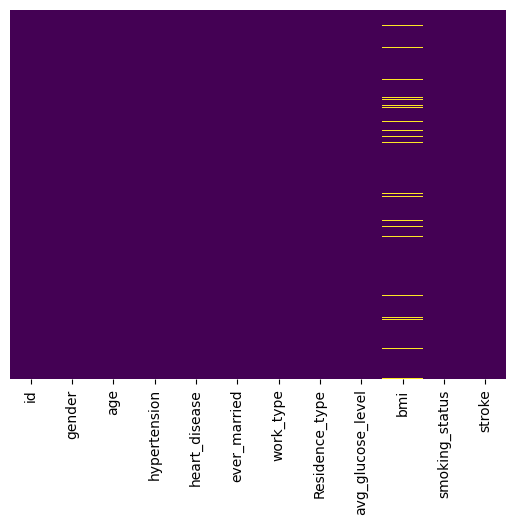

In [8]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Drop or fill
As we saw in the previous cells the column <em>bmi</em> is the only one with missing values, so we decided to fill those values with the bmi's gender mean becuase that's the least impactful way to handle the null values for the predictor model.



In [9]:
data['bmi'].head()

0    36.6
1     NaN
2    32.5
3    34.4
4    24.0
Name: bmi, dtype: float64

In [10]:
data[data['bmi'].isnull()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [11]:
male_data = data[data['gender'] == 'Male']['bmi'].mean()

female_data = data[data['gender'] == 'Female']['bmi'].mean()

data['bmi'] = data.apply(lambda row: male_data if pd.isna(row['bmi']) and row['gender'] == 'Male' else row['bmi'], axis=1)
data['bmi'] = data.apply(lambda row: female_data if pd.isna(row['bmi']) and row['gender'] == 'Female' else row['bmi'], axis=1)

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.065758,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In the next cell we verified if there are columns with unique values, which is not the case for this dataset, but if there was we would drop them.

In [12]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   420
smoking_status          4
stroke                  2
dtype: int64

In the next step, we drop the feature <em>id</em> because it isn't relevant for what we want to predict.

In [13]:
data.drop('id',axis=1,inplace=True)

### Outliers

In [ ]:
data.bmi.describe()

<Axes: xlabel='bmi'>

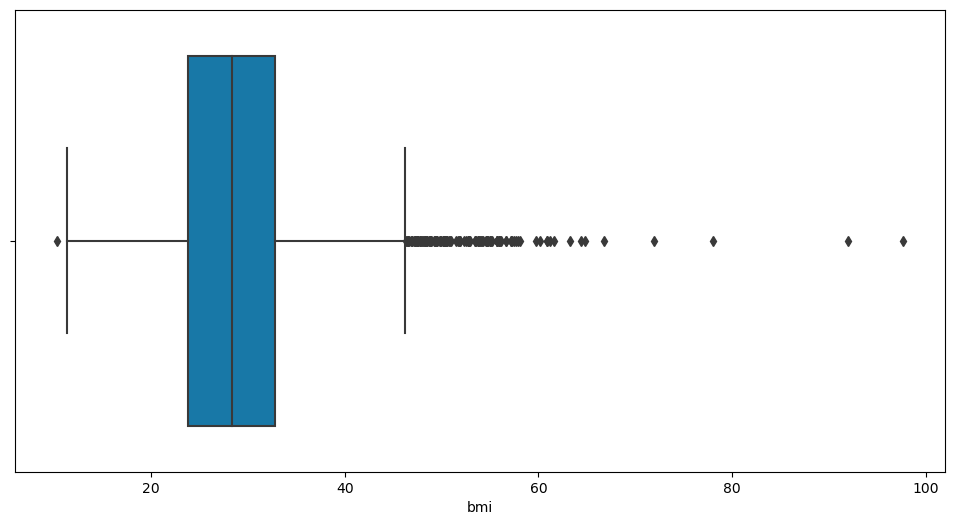

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['bmi'],palette='winter')

In [15]:
mean = data.loc[data['bmi']<70, 'bmi'].mean()
data.loc[data.bmi > 70, 'bmi'] = np.nan
data.loc[data.bmi < 11, 'bmi'] = np.nan
data.fillna(mean,inplace=True)

<Axes: xlabel='bmi'>

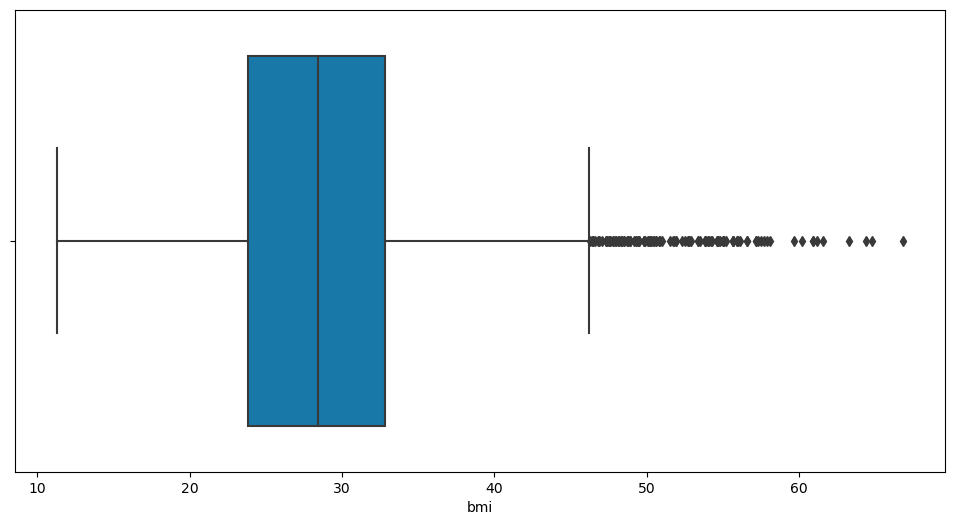

In [16]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['bmi'],palette='winter')

### Reformating Data

In the next step, we wan't to convert age to an int type because floating ages doesn't exists.

In [17]:
data['age'] = data['age'].astype(int)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,29.065758,never smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   int64  
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 439.3+ KB


## 2. Handling categoric data

Let's see the feature <em>gender</em>:

In [19]:
print(data['gender'].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


In [20]:
print(data['gender'].value_counts().count())

3


Let's create a barplot of <em>Frequency Distribution of Cases</em>

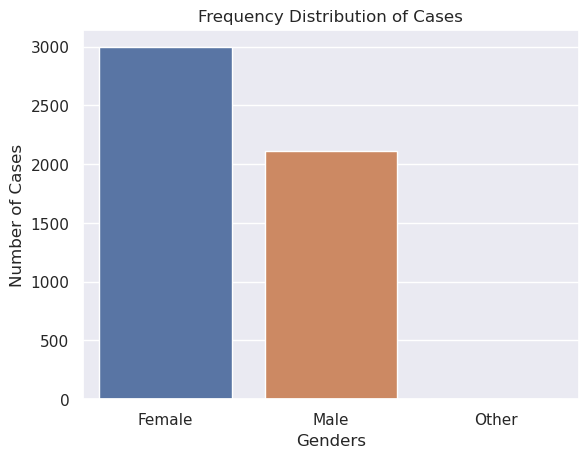

In [21]:
gender_count = data['gender'].value_counts()
sns.set(style = "darkgrid")
sns.barplot(x = gender_count.index, y = gender_count.values)
plt.title('Frequency Distribution of Cases')
plt.ylabel('Number of Cases', fontsize=12)
plt.xlabel('Genders', fontsize=12)
plt.show()

Let's create a pie plot of <em>Category Distribution of Cases</em>

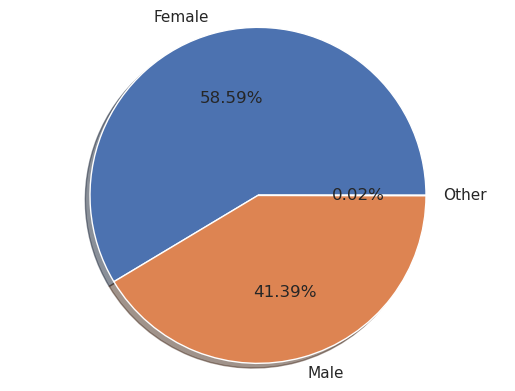

In [22]:
labels = data['gender'].astype('category').cat.categories.tolist()
counts = data['gender'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%',shadow=True)
ax1.axis('equal')
plt.show()


We used this operation to prepare the categorical data for the machine learning algorithms that require numerical inputs, which it's our case.

In [23]:
data['ever_married'] = pd.factorize(data['ever_married'])[0] + 1
data['work_type'] = pd.factorize(data['work_type'])[0] + 1
data['Residence_type'] = pd.factorize(data['Residence_type'])[0] + 1
data['smoking_status'] = pd.factorize(data['smoking_status'])[0] + 1
data['gender'] = pd.factorize(data['gender'])[0] + 1

data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67,0,1,1,1,1,228.69,36.600000,1,1
1,2,61,0,0,1,2,2,202.21,29.065758,2,1
2,1,80,0,1,1,1,2,105.92,32.500000,2,1
3,2,49,0,0,1,1,1,171.23,34.400000,3,1
4,2,79,1,0,1,2,2,174.12,24.000000,2,1


# Exploratory Data Analysis


In [24]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67,0,1,1,1,1,228.69,36.600000,1,1
1,2,61,0,0,1,2,2,202.21,29.065758,2,1
2,1,80,0,1,1,1,2,105.92,32.500000,2,1
3,2,49,0,0,1,1,1,171.23,34.400000,3,1
4,2,79,1,0,1,2,2,174.12,24.000000,2,1


Let's analyze through a heatmap

<Axes: >

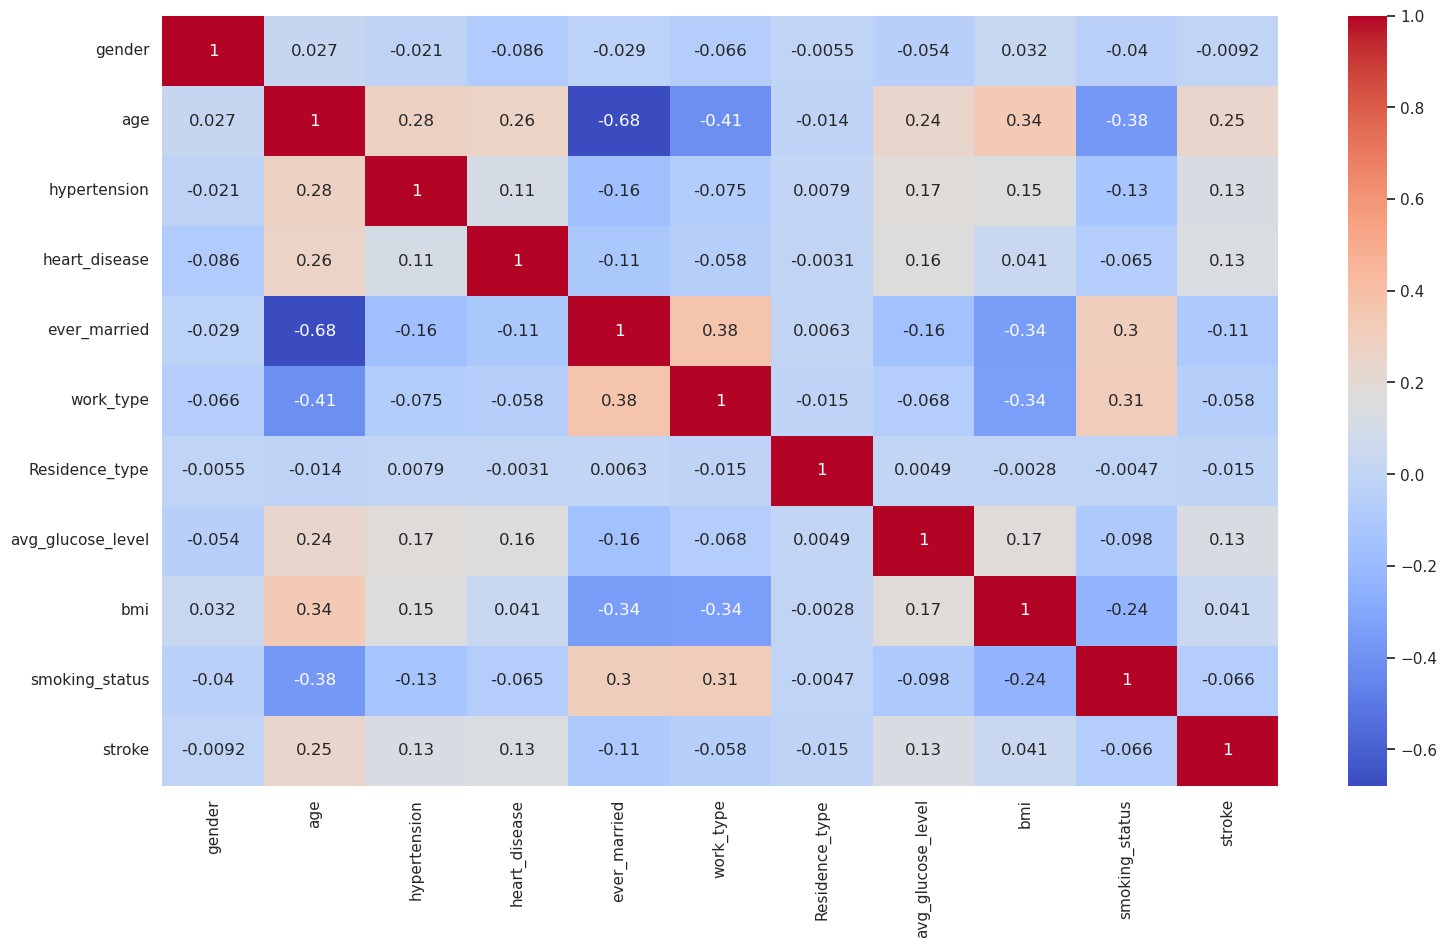

In [25]:
plt.subplots(figsize=(18,10))
stroke_corr = data.corr(method='pearson')
sns.heatmap(stroke_corr, annot = True, cmap='coolwarm')

Throught the heatmap observation, it is possible to find some columns with no correlation with the target column(<em>stroke</em>).

So, we dopred them to improve the model performance.

In [26]:
data.drop('ever_married',axis=1,inplace=True)
data.drop('Residence_type',axis=1,inplace=True)
data.drop('work_type',axis=1,inplace=True)
data.drop('smoking_status',axis=1,inplace=True)
data.drop('gender',axis=1,inplace=True)

## Normalization

The purpose of this scaling is to ensure that "BMI" values ​​are within a consistent and standardized range.

This is important for certain machine learning algorithms, especially those that are sensitive to the size of input features and want to prevent a single feature from overwhelming the size of other features.



In [71]:
data['bmi'] = (data['bmi'] - data['bmi'].mean()) / (data['bmi'].max() - data['bmi'].min())
data['avg_glucose_level'] = (data['avg_glucose_level'] - data['avg_glucose_level'].mean()) / (data['avg_glucose_level'].max() - data['avg_glucose_level'].min())

Let's visualize the heatmap with the improvements

<Axes: >

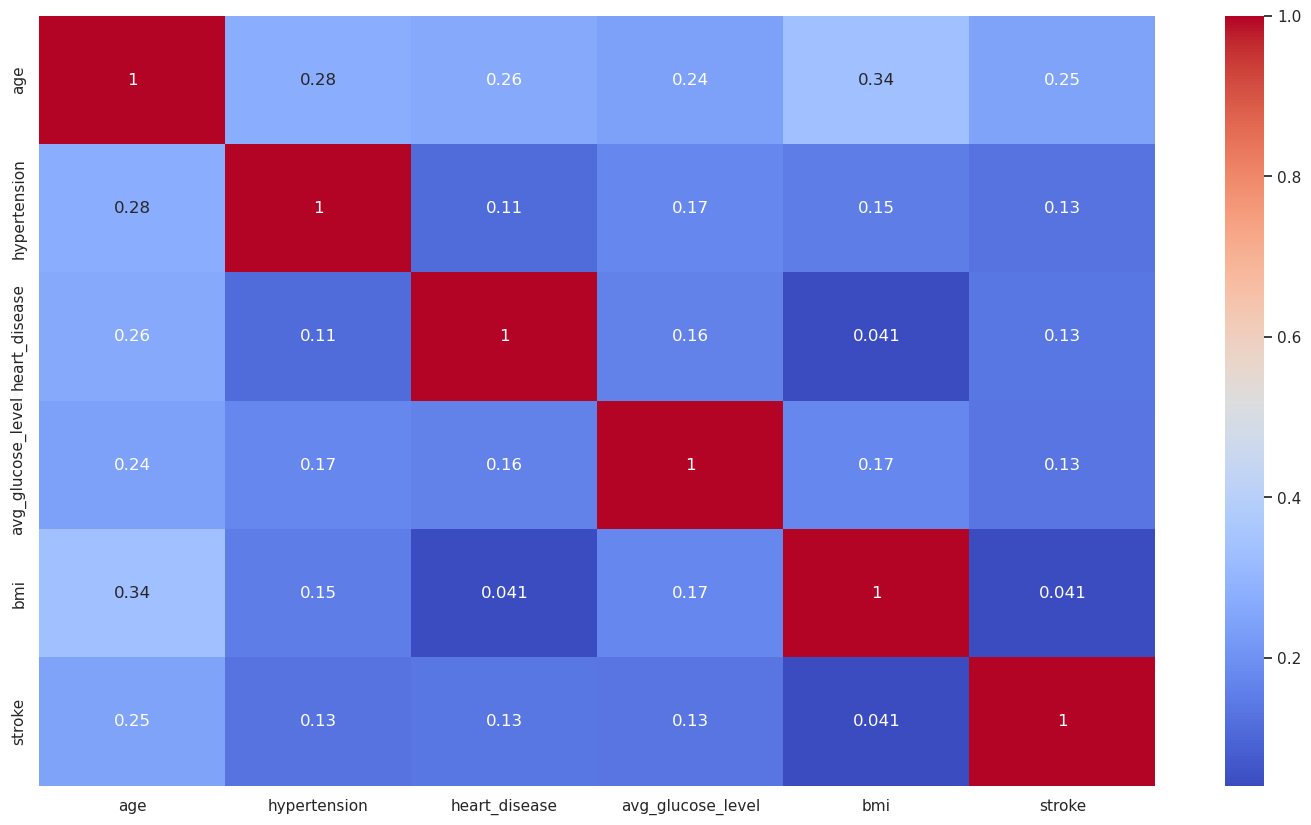

In [72]:
plt.subplots(figsize=(18,10))
stroke_corr = data.corr(method='pearson')
sns.heatmap(stroke_corr, annot = True, cmap='coolwarm')

Let's see with a pairplot

/home/gsenra/miniconda3/envs/DAAenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


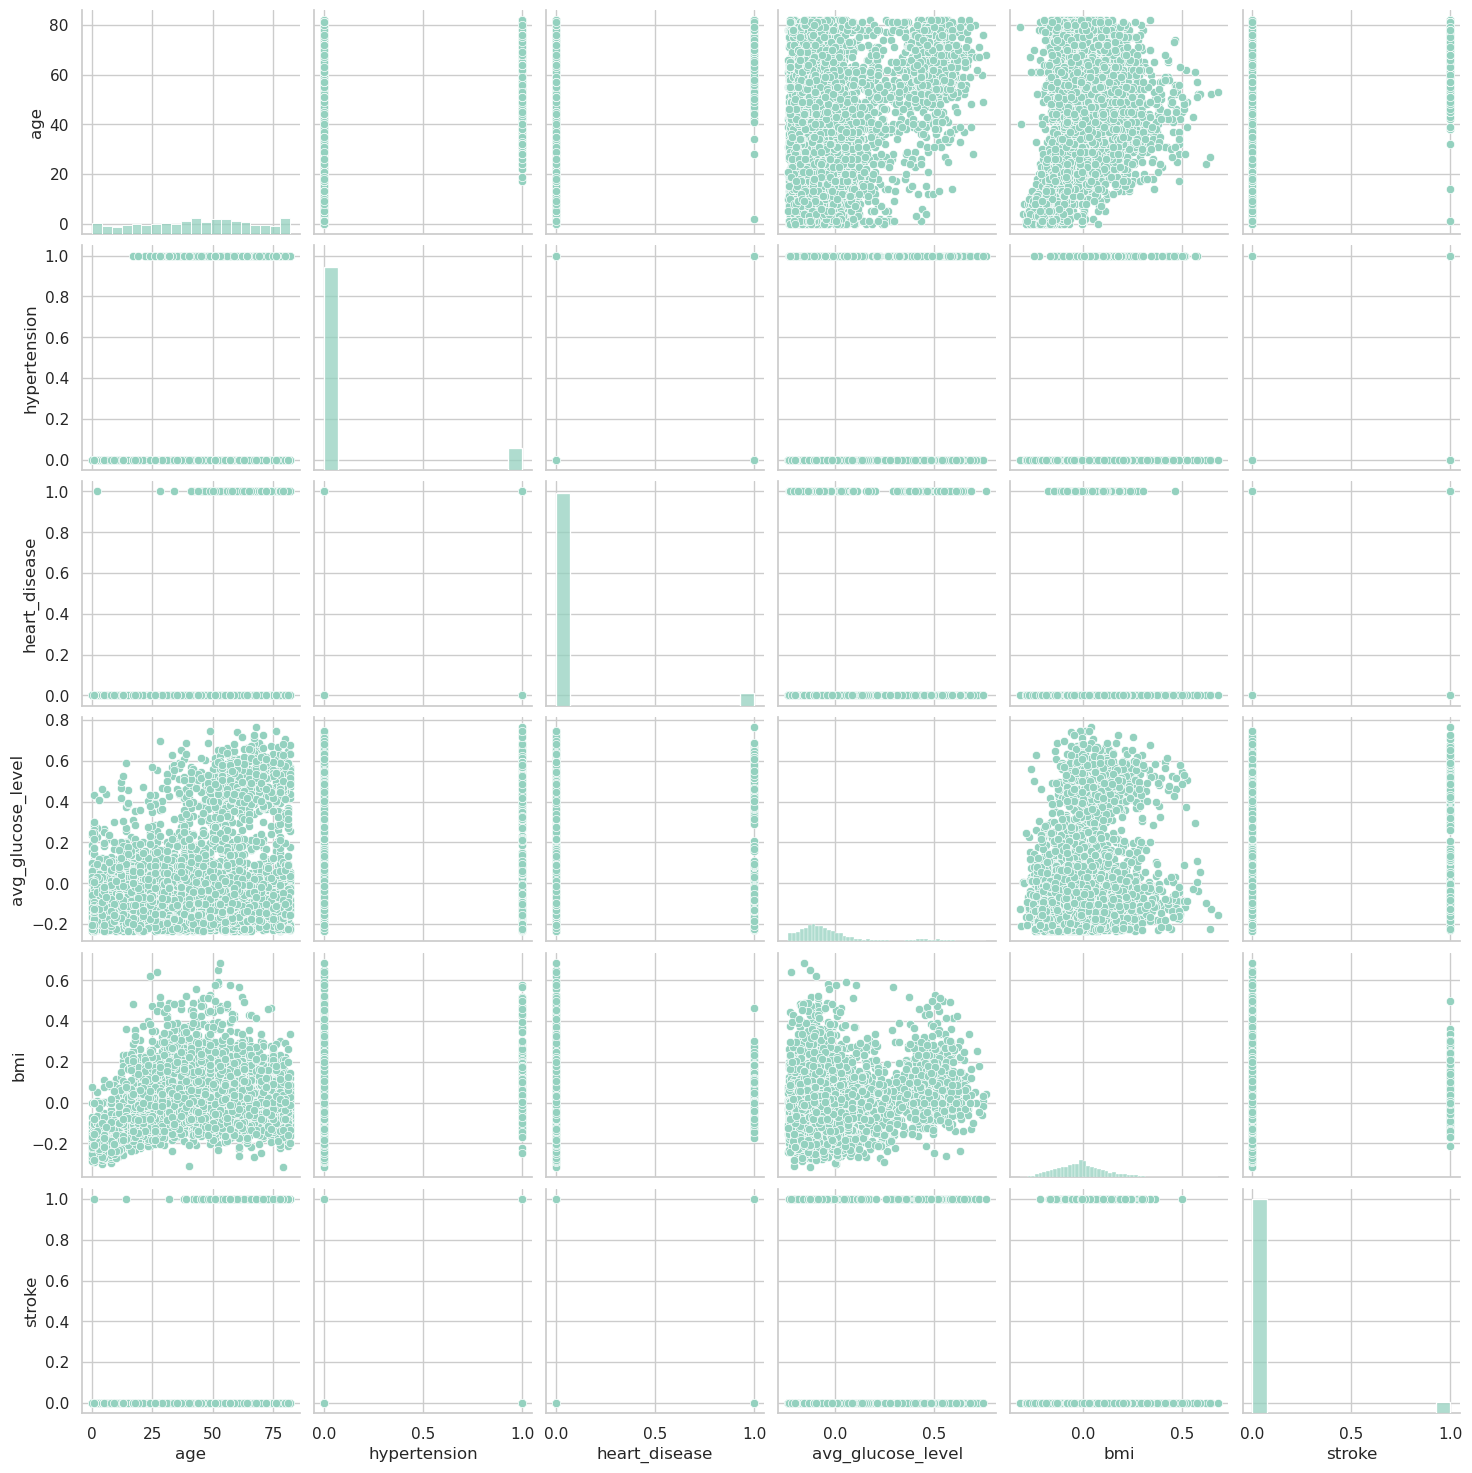

In [73]:
sns.pairplot(data)

It's hard to analyze the relation of all features. Let's create jointplots between the features with notice a relationship.

Jointplot of <em>stroke vs. age</em>

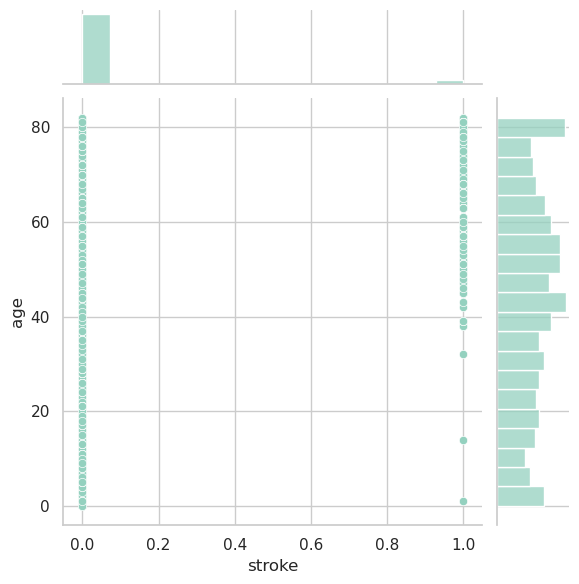

In [74]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.jointplot(x='stroke',y='age',data=data)

Jointplot <em>bmi vs. age</em>

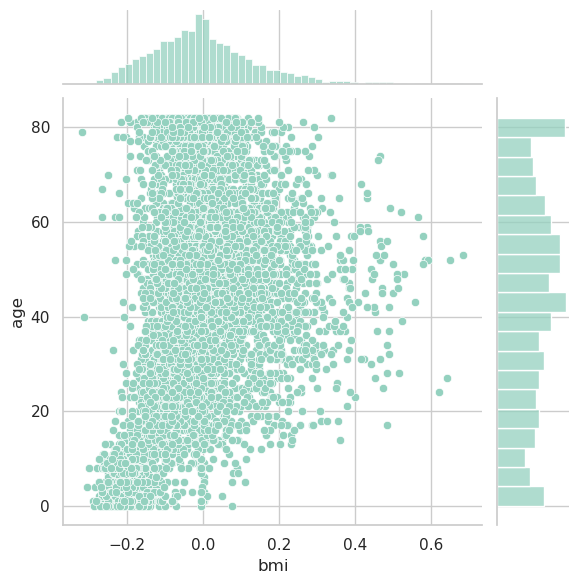

In [75]:
sns.jointplot(x='bmi',y='age',data=data)

Jointplot <em>hypertension vs. age</em>

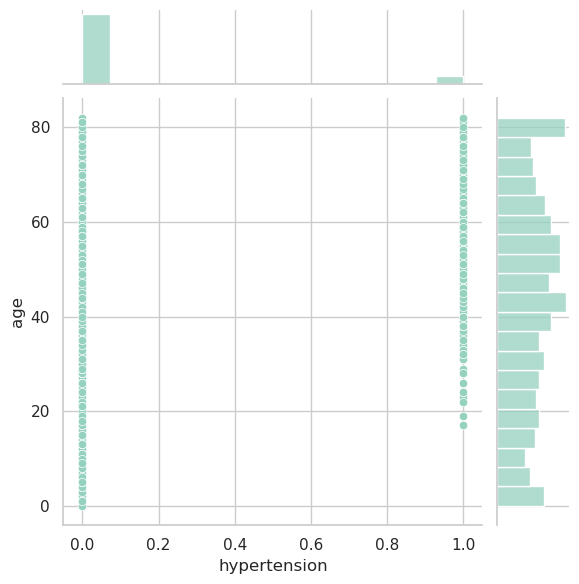

In [76]:
sns.jointplot(x = 'hypertension', y = 'age', data = data)

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5110 non-null   int64  
 1   hypertension       5110 non-null   int64  
 2   heart_disease      5110 non-null   int64  
 3   avg_glucose_level  5110 non-null   float64
 4   bmi                5110 non-null   float64
 5   stroke             5110 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 239.7 KB


In [78]:
data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67,0,1,0.565702,0.139616,1
1,61,0,0,0.443460,0.003864,1
2,80,0,1,-0.001051,0.065742,1
3,49,0,0,0.300445,0.099977,1
4,79,1,0,0.313786,-0.087411,1


## Train Test Split

We did the train test split to avoid overfitting and to be able to test our model with new data.

In [79]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=2021)

### Set up the dataframe

In [80]:
data_feat = train_data.drop(['stroke'], axis = 1)

In [81]:
data_target = train_data.stroke

In [82]:
x_train = data_feat
y_train= np.ravel(data_target) 

In [83]:
test_feat = test_data.drop(['stroke'], axis = 1)

In [84]:
test_target = test_data.stroke

In [85]:
test_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
2085,70,0,0,-0.155053,0.027905,0
2813,43,0,0,-0.069327,0.090968,0
451,13,0,0,0.074611,-0.244167,0
3133,16,0,0,-0.087654,-0.011735,0
5005,21,0,0,-0.160685,-0.087411,0


In [86]:
x_test = test_feat
y_test = np.ravel(test_target)

<Axes: xlabel='Stroke', ylabel='count'>

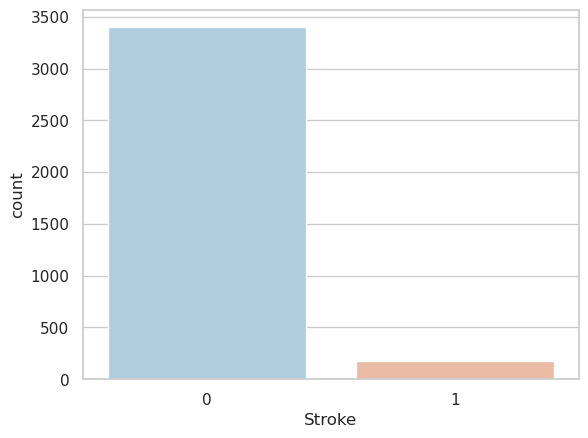

In [87]:
sns.set_style('whitegrid')
sns.countplot(x='Stroke',data=pd.DataFrame(y_train, columns=['Stroke']),palette='RdBu_r')

<Axes: xlabel='Stroke', ylabel='count'>

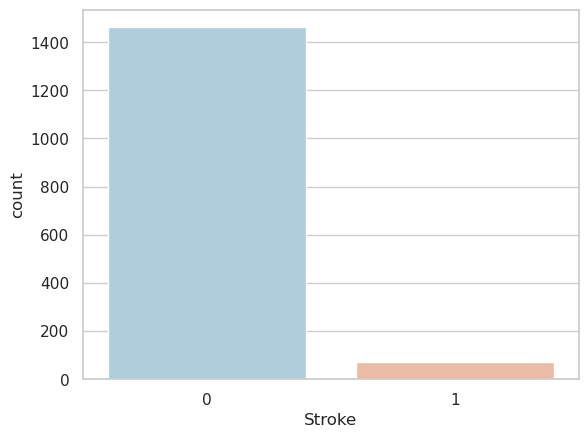

In [88]:
sns.set_style('whitegrid')
sns.countplot(x='Stroke',data=pd.DataFrame(y_test, columns=['Stroke']),palette='RdBu_r')

As we can see from the previous graphs, the data is imbalanced, so we applied an oversampling technique to balance the data and improve the model performance.

In [89]:
!pip install imblearn 

### Oversampling the data

In [90]:
count0, count1 = train_data.stroke.value_counts()
print("negativo -> ",count0,"positivo -> ",count1)

x = data.drop(['stroke'], axis = 1)
y = np.ravel(data.stroke)


sm = SMOTE(sampling_strategy='auto',random_state=1000)
x_train_s, y_train_s = sm.fit_resample(x, y)

train_data_OS = pd.DataFrame(x_train_s,columns=x_train_s.columns)
train_data_OS['stroke'] = y_train_s

train_data_OS.head()
mask = train_data_OS.isin(test_data.to_dict(orient='list')).all(axis=1)

# Filtrar as linhas que não estão em df2
train_data_OS = train_data_OS[~mask]

train_data_OS.head()


negativo ->  3399 positivo ->  178


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
2,80,0,1,-0.001051,0.065742,1
3,49,0,0,0.300445,0.099977,1
4,79,1,0,0.313786,-0.087411,1
5,81,0,0,0.369598,0.002679,1
6,74,1,1,-0.166456,-0.026149,1


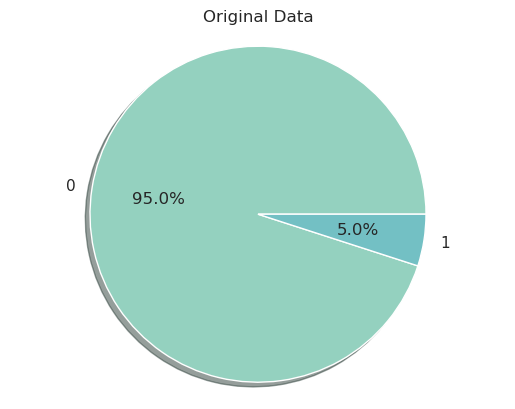

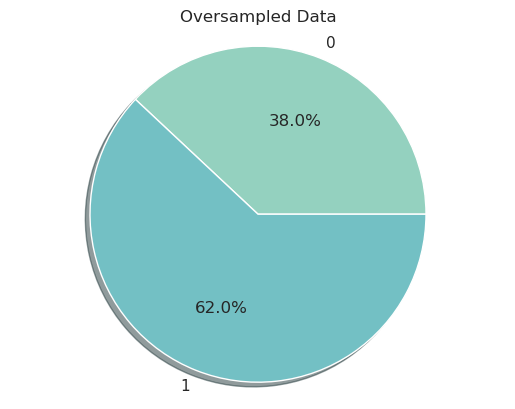

In [91]:
# # Primeiro Gráfico
# plt.subplot(1, 2, 1)
labels = train_data['stroke'].astype('category').cat.categories.tolist()
counts = train_data['stroke'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Original Data')
plt.show()
# Segundo Gráfico
# plt.subplot(1, 2, 2)
labels = train_data_OS['stroke'].astype('category').cat.categories.tolist()
counts = train_data_OS['stroke'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig2, ax2 = plt.subplots()
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax2.axis('equal')
plt.title('Oversampled Data')


# Exibe os gráficos
plt.show()

In [92]:
data_OS_feat = train_data_OS.drop(['stroke'], axis = 1)

In [93]:
data_OS_target = train_data_OS.stroke

In [94]:
x_train_OS = data_OS_feat
y_train_OS = np.ravel(data_OS_target)


In [95]:
y_array = np.array(y_train_OS)
df_y = pd.DataFrame(y_array, columns=['Stroke'])

In [96]:
print(df_y['Stroke'].value_counts())


Stroke
1    4770
0    2926
Name: count, dtype: int64


<Axes: xlabel='Stroke', ylabel='count'>

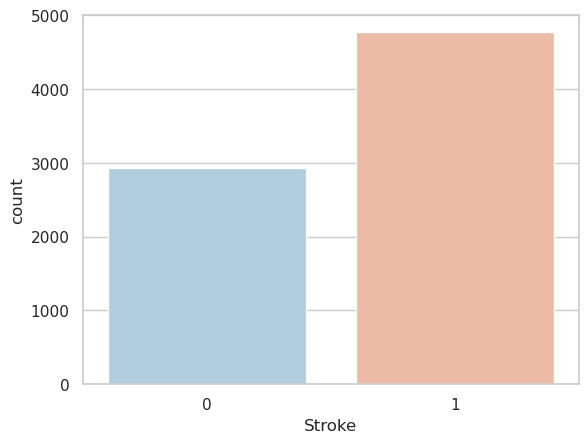

In [97]:
# Criando o gráfico
sns.set_style('whitegrid')
sns.countplot(x='Stroke', data=df_y, palette='RdBu_r')

Now, we can see, the data is more balanced with respect to the target column <em>stroke</em>.

## Train the Support Vector Classifier

### DecisionTreeClassifier (without oversampling)

In [98]:
modelDecisionTree = DecisionTreeClassifier()
scores = cross_val_score(modelDecisionTree, data_feat, data_target, cv=10)
print("Result for Decision Tree: %0.4f accuracy with standard deviation of %0.2f" % (scores.mean(), scores.std()))
#Train the model using the training sets y_pred=clf.predict(X_test)

Result for Decision Tree: 0.9038 accuracy with standard deviation of 0.01


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1462
           1       0.21      0.21      0.21        71

    accuracy                           0.93      1533
   macro avg       0.59      0.59      0.59      1533
weighted avg       0.93      0.93      0.93      1533



<function matplotlib.pyplot.show(close=None, block=None)>

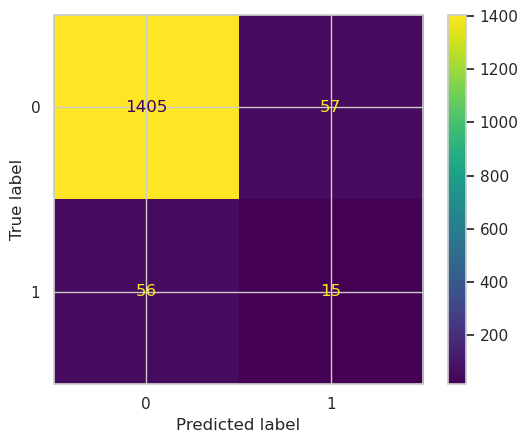

In [99]:
modelDecisionTree.fit(x_train,y_train)
predictions = modelDecisionTree.predict(x_test)
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show

### DecisionTreeClassifier (with oversampling)

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1462
           1       0.17      0.90      0.29        71

    accuracy                           0.79      1533
   macro avg       0.58      0.84      0.58      1533
weighted avg       0.96      0.79      0.85      1533

79.06 accuracy


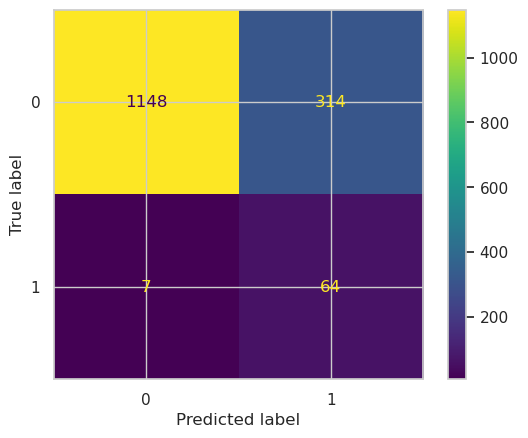

In [100]:
modelDecisionTree.fit(x_train_OS,y_train_OS)
predictions = modelDecisionTree.predict(x_test)
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show
print("%0.2f accuracy" % ((accuracy_score(y_test,predictions))*100))

In [101]:
test_data.stroke.value_counts()

stroke
0    1462
1      71
Name: count, dtype: int64

### Random Forest

In [104]:
modelRandomForest = RandomForestClassifier(n_estimators = 500)
scores = cross_val_score(modelRandomForest, x, y, cv=10)
print("Result for Random Forest: %0.4f accuracy with standard deviation of %0.2f" % (scores.mean(), scores.std()))

Result for Random Forest: 0.9477 accuracy with standard deviation of 0.00


              precision    recall  f1-score   support

           0       1.00      0.79      0.88      1462
           1       0.18      0.93      0.30        71

    accuracy                           0.80      1533
   macro avg       0.59      0.86      0.59      1533
weighted avg       0.96      0.80      0.85      1533



<function matplotlib.pyplot.show(close=None, block=None)>

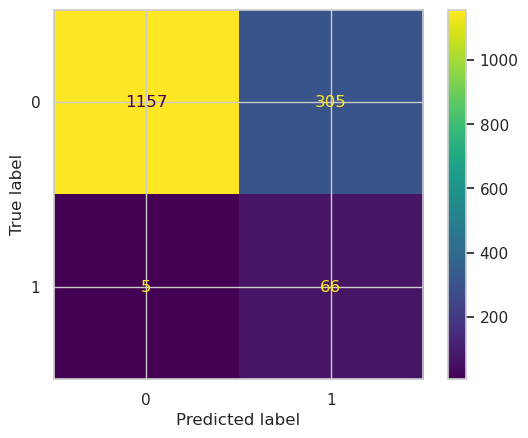

In [105]:
modelRandomForest.fit(x_train_OS,y_train_OS)
predictions = modelRandomForest.predict(x_test)
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show

### SVC with GridSearchCV

In [106]:
param_grid={'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001],'kernel':['rbf']}

grid = GridSearchCV(SVC(random_state=1000),param_grid,refit=True,verbose=3)

In [107]:
#Avaliar os melhores parâmetros
#scores = cross_val_score(grid, x_train_OS, y_train_OS, cv=5)    

In [108]:
#scores

In [109]:
#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [110]:
grid.fit(x_train_OS,y_train_OS)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.823 total time=   2.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.827 total time=   2.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.815 total time=   2.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.828 total time=   2.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.825 total time=   2.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.795 total time=   2.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.791 total time=   3.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.804 total time=   3.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.784 total time=   3.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.805 total time=   2.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.796 total time=   2.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.788 total time=   2.6s
[CV 3/5] END .....C=0.1, gam

GridSearchCV(estimator=SVC(random_state=1000),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1462
           1       0.16      0.90      0.27        71

    accuracy                           0.77      1533
   macro avg       0.57      0.83      0.56      1533
weighted avg       0.95      0.77      0.84      1533



<function matplotlib.pyplot.show(close=None, block=None)>

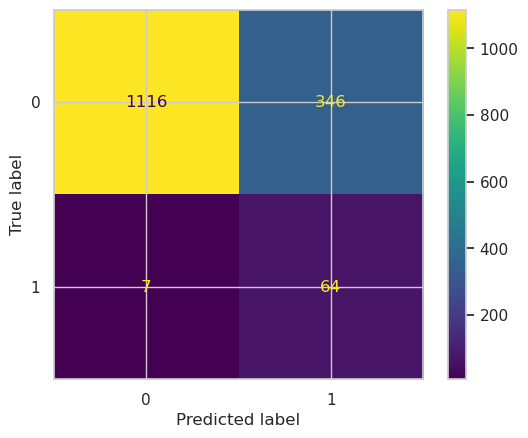

In [111]:
predictions = grid.predict(x_test)

print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show

### Predictions and Evaluations

Our main goal was to minimize the number of false negative cases, emphasizing a high recall rate. As we can see in the matrix above we sucessfully acomplished the objective.
The primary reasons for the predictions success were:

- Handling missing values: the missing values in the 'bmi' column were replaced by the gender's mean

- Normalization: for the data standardization

- Drop unnecessary columns: the columns with no correlation with the target (stroke) have been dropped

- Oversampling: due to the lack of positive cases in the target label the model didn't have positives cases enough to get a great accuracy, the solution was oversample the dataset, in order to rebalance the the data and consequently get a better prediction accuracy 